# 라이브러리 임포트

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
from torch.autograd import Variable

from bs4 import BeautifulSoup
from selenium import webdriver
from pykrx import stock

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from tqdm.auto import tqdm
import sweetviz as sv
from sklearn.preprocessing import MinMaxScaler

import matplotlib

import datetime as dt, itertools

scaler = MinMaxScaler()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   #'cuda:0, cuda:1, cuda:2'

# 자료 전처리

In [2]:
path = os.getcwd() + '/UNID'
print(path)
src = ['281520', '283640', '310420']  # UNID의 주요 원자재 정의
terms = ['1408-1808', '1809-2209']  # 조회한 기간
src_name = {
    '281520' : '가성칼륨',
    '283640' : '탄산칼륨',
    '310420' : '염화칼륨'
}
src_name

C:\Users\C.W Lee\OneDrive\FE/UNID


{'281520': '가성칼륨', '283640': '탄산칼륨', '310420': '염화칼륨'}

In [3]:
# 칼륨계 수출입 자료 로드
def load_trade_csv(code, term):
    try :  # utf-8로 디코딩된 csv 로드
        df = pd.read_csv(path + f'/data/{code}_{term}.csv', encoding = 'utf-8', skipinitialspace = True)
    except :  # euc-kr로 디코딩 csv 로드
        df = pd.read_csv(path + f'/data/{code}_{term}.csv', encoding = 'euc-kr', skipinitialspace = True)
    # yyyy-mm 방식의 월단위로 datetime 자료형 정렬
    df['기간'] = pd.to_datetime(df['기간'].map('{:.2f}'.format), format='%Y.%m').dt.strftime('%Y-%m')
    # 한글 컬럼명을 영어로 변경 _name : 해당 원소명, _exp : 수출, _imp : 수입, _weight : 중량, _sum : 금액, _margin : 수지
    df.columns = [f'date', f'{code}_name', f'{code}_code', f'{code}_exp_weight', f'{code}_imp_weight', f'{code}_exp_sum', f'{code}_imp_sum', f'{code}_margin']
    df.set_index('date', drop = True, append = False, inplace = True)
    return df

# 수출입데이터(수출입 중량, 수출입 금액, 수지) 스케일링
def preprocessing(src_df) : 
    for a, code in enumerate(src) :
        src_df = src_df.drop([f'{code}_name', f'{code}_code'], axis = 1)  # 날짜를 인덱스로 학습용 데이터 추출
        # 0 ~ 1 로 MinMaxScaling
        src_df.loc[:, f'{code}_exp_weight':f'{code}_margin'] = scaler.fit_transform(src_df.loc[:, f'{code}_exp_weight':f'{code}_margin'].astype(float))
    return src_df

# UNID 종가 스크리닝
def read_stock(df, code):
    # 수출입데이터의 시작월과 종료월 추출
    dt_pst, dt_now = df.index[0].replace('-', '')+'01', df.index[-1].replace('-', '')+'28'
    # 추출한 시작월부터 종료월 기간까지 UNID 월별 주가 추출
    unid = stock.get_market_ohlcv(dt_pst, dt_now, code, freq = 'm')
    unid.index = df.index  # 날짜 인덱스 자료형 통일
    unid = pd.DataFrame({'close' : unid['종가']})  # 종가만 추출
    return unid

In [4]:
# 숫자 데이터 전처리
for a, code in enumerate(src) :
    for b, term in enumerate(terms) :
        print(code, term)
        if b == 0 :
            src_df = load_trade_csv(code, term)
        elif term == '1408-1808' :  # 자료 단위가 5개년이므로 과거자료를 위에
            src_df = pd.concat([src_df, load_trade_csv(code, term)], axis = 1, join = 'inner')
        elif term == '1809-2209' :  # 최근자료를 아래에 붙임으로 날짜 내림차순으로 정렬
            src_df = pd.concat([src_df, load_trade_csv(code, term)], axis = 0, join = 'inner')
        for c in range(len(src_df.columns)):  # 
            try :
                src_df.iloc[:, c] = src_df.iloc[:, c].str.strip()  # 문자열 내 공백을 제거
                src_df.iloc[:, c] = src_df.iloc[:, c].str.replace(',', '')  # 천단위 구분자 ',' 제거
            except : 
                pass
    if a == 0 :
        df = src_df
    else :
        df = pd.concat([df, src_df], axis = 1, join = 'inner')
        
src = preprocessing(df)
dst = read_stock(src, '014830')

# 수출입데이터와 유니드 주가 결합
data = pd.concat([src, dst], axis=1)

# 주가 상승 시 1, 하락시 0으로 Target Column 생성
data['tgt'] = 0.5
for i in range(len(data)):
    if i == len(data) - 1:
        break
    else :
        if data['close'][i+1] - data['close'][i] > 0 :
            data['tgt'][i] = 1
        else :
            data['tgt'][i] = 0
data

281520 1408-1808
281520 1809-2209
283640 1408-1808
283640 1809-2209
310420 1408-1808
310420 1809-2209


C:\Users\C.W Lee\AppData\Local\Temp\ipykernel_32048\810417559.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tgt'][i] = 0
C:\Users\C.W Lee\AppData\Local\Temp\ipykernel_32048\810417559.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tgt'][i] = 1


,281520_exp_weight,281520_imp_weight,281520_exp_sum,281520_imp_sum,281520_margin,283640_exp_weight,283640_imp_weight,283640_exp_sum,283640_imp_sum,283640_margin,310420_exp_weight,310420_imp_weight,310420_exp_sum,310420_imp_sum,310420_margin,close,tgt
date,,,,,,,,,,,,,,,,,
2014-08,0.136408,0.180326,0.130382,0.297149,0.144874,0.232414,0.492205,0.275554,0.564286,0.265629,0.000000,0.321832,0.000000,0.125806,0.873964,47250,0.0
2014-09,0.262258,0.256957,0.148323,0.485746,0.156626,0.312218,0.289532,0.359604,0.216071,0.367897,0.000000,0.167378,0.000000,0.062547,0.937334,43764,1.0
2014-10,0.213528,0.265326,0.141928,0.404605,0.152885,0.200778,0.425167,0.240445,0.328571,0.240773,0.002299,0.129822,0.003550,0.050470,0.949613,44135,0.0
2014-11,0.277746,0.000000,0.142532,0.062500,0.164496,0.128161,0.151448,0.176365,0.125000,0.184785,0.000000,0.434386,0.000000,0.164826,0.834875,42429,1.0
2014-12,0.230704,0.373152,0.133509,0.377193,0.145403,0.252098,0.109131,0.269662,0.051786,0.283622,0.000015,0.368666,0.000169,0.141453,0.858298,42652,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05,0.755997,0.543913,0.563521,0.914474,0.555285,0.844743,0.651670,1.000000,0.701786,1.000000,0.005247,0.627889,0.015723,0.416969,0.583087,127500,0.0
2022-06,0.872638,0.299130,0.626048,0.563596,0.628692,0.569708,0.753007,0.736149,0.744643,0.728178,0.010495,0.618979,0.031107,0.435801,0.565004,96400,0.0
2022-07,0.656005,0.665543,0.683175,1.000000,0.671396,0.539666,0.242984,0.874212,0.242857,0.892878,0.008396,0.061442,0.034827,0.055912,0.945752,96100,1.0


In [5]:
# 보조 학습 데이터 로드
extras = ['KOR2Y', 'CAD_KRW', 'CAD_CNH', 'CNY_KRW', 'CCUS']  # 한국 2년물 수익률, 캐나다/원. 캐나다/위안, 위안/원, CCUS 구글 트렌드
for i, extra in enumerate(extras) :
    if extra != 'CCUS' :  # 인베스팅닷컴 자료는 역순으로 저장되어 있으므로 역순하여 로드
        csv = pd.read_csv(path + f'/data/{extra}_1408-2209.csv').loc[::-1].reset_index(drop=True).iloc[:,1]
    elif extra == 'CCUS' :  # 구글 트렌드 자료 로드
        csv = pd.read_csv(path + f'/data/{extra}_1408-2209.csv').reset_index(drop=True).iloc[:,1]
    
    try :  # 천단위 구분자 ',' 제거
        csv = csv.str.replace(',', '')
    except :
        pass
    
    temp = pd.concat([csv, pd.Series(data.index)], axis=1).set_index('date')  # 기존 자료 인덱스로 정리
    
    if extra != 'CCUS' :
        temp.columns = [f'{extra}_close']  # 금융 데이터는 종가만 추출하고 컬럼명 정의
    elif extra == 'CCUS' :
        temp.columns = [f'{extra}_interest']  # 구글 트렌드 자료 컬럼명 정의
    if i == 0 :
        df = temp
    else :
        df = pd.concat([df, temp], axis=1)
        
df.iloc[:,:] = scaler.fit_transform(df)  # 0 ~ 1 로 MinMaxScaling
data = pd.concat([data.iloc[:, :-2], df, data.iloc[:, -2:]], axis=1)  # Target 컬럼 앞에 삽입
data

,281520_exp_weight,281520_imp_weight,281520_exp_sum,281520_imp_sum,281520_margin,283640_exp_weight,283640_imp_weight,283640_exp_sum,283640_imp_sum,283640_margin,...,310420_exp_sum,310420_imp_sum,310420_margin,KOR2Y_close,CAD_KRW_close,CAD_CNH_close,CNY_KRW_close,CCUS_interest,close,tgt
date,,,,,,,,,,,,,,,,,,,,,
2014-08,0.136408,0.180326,0.130382,0.297149,0.144874,0.232414,0.492205,0.275554,0.564286,0.265629,...,0.000000,0.125806,0.873964,0.492853,0.513008,1.000000,0.099250,0.022472,47250,0.0
2014-09,0.262258,0.256957,0.148323,0.485746,0.156626,0.312218,0.289532,0.359604,0.216071,0.367897,...,0.000000,0.062547,0.937334,0.449971,0.556188,0.855411,0.263617,0.022472,43764,1.0
2014-10,0.213528,0.265326,0.141928,0.404605,0.152885,0.200778,0.425167,0.240445,0.328571,0.240773,...,0.003550,0.050470,0.949613,0.405660,0.602926,0.771747,0.355120,0.044944,44135,0.0
2014-11,0.277746,0.000000,0.142532,0.062500,0.164496,0.128161,0.151448,0.176365,0.125000,0.184785,...,0.000000,0.164826,0.834875,0.385363,0.703295,0.727234,0.489954,0.000000,42429,1.0
2014-12,0.230704,0.373152,0.133509,0.377193,0.145403,0.252098,0.109131,0.269662,0.051786,0.283622,...,0.000169,0.141453,0.858298,0.394511,0.551296,0.675748,0.370128,0.044944,42652,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05,0.755997,0.543913,0.563521,0.914474,0.555285,0.844743,0.651670,1.000000,0.701786,1.000000,...,0.015723,0.416969,0.583087,0.590623,0.737448,0.603454,0.611232,0.808989,127500,0.0
2022-06,0.872638,0.299130,0.626048,0.563596,0.628692,0.569708,0.753007,0.736149,0.744643,0.728178,...,0.031107,0.435801,0.565004,0.808748,0.817539,0.516250,0.757444,0.887640,96400,0.0
2022-07,0.656005,0.665543,0.683175,1.000000,0.671396,0.539666,0.242984,0.874212,0.242857,0.892878,...,0.034827,0.055912,0.945752,0.661521,0.898386,0.598413,0.781409,0.910112,96100,1.0


# 수집 데이터와 유니드 주가 plot

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


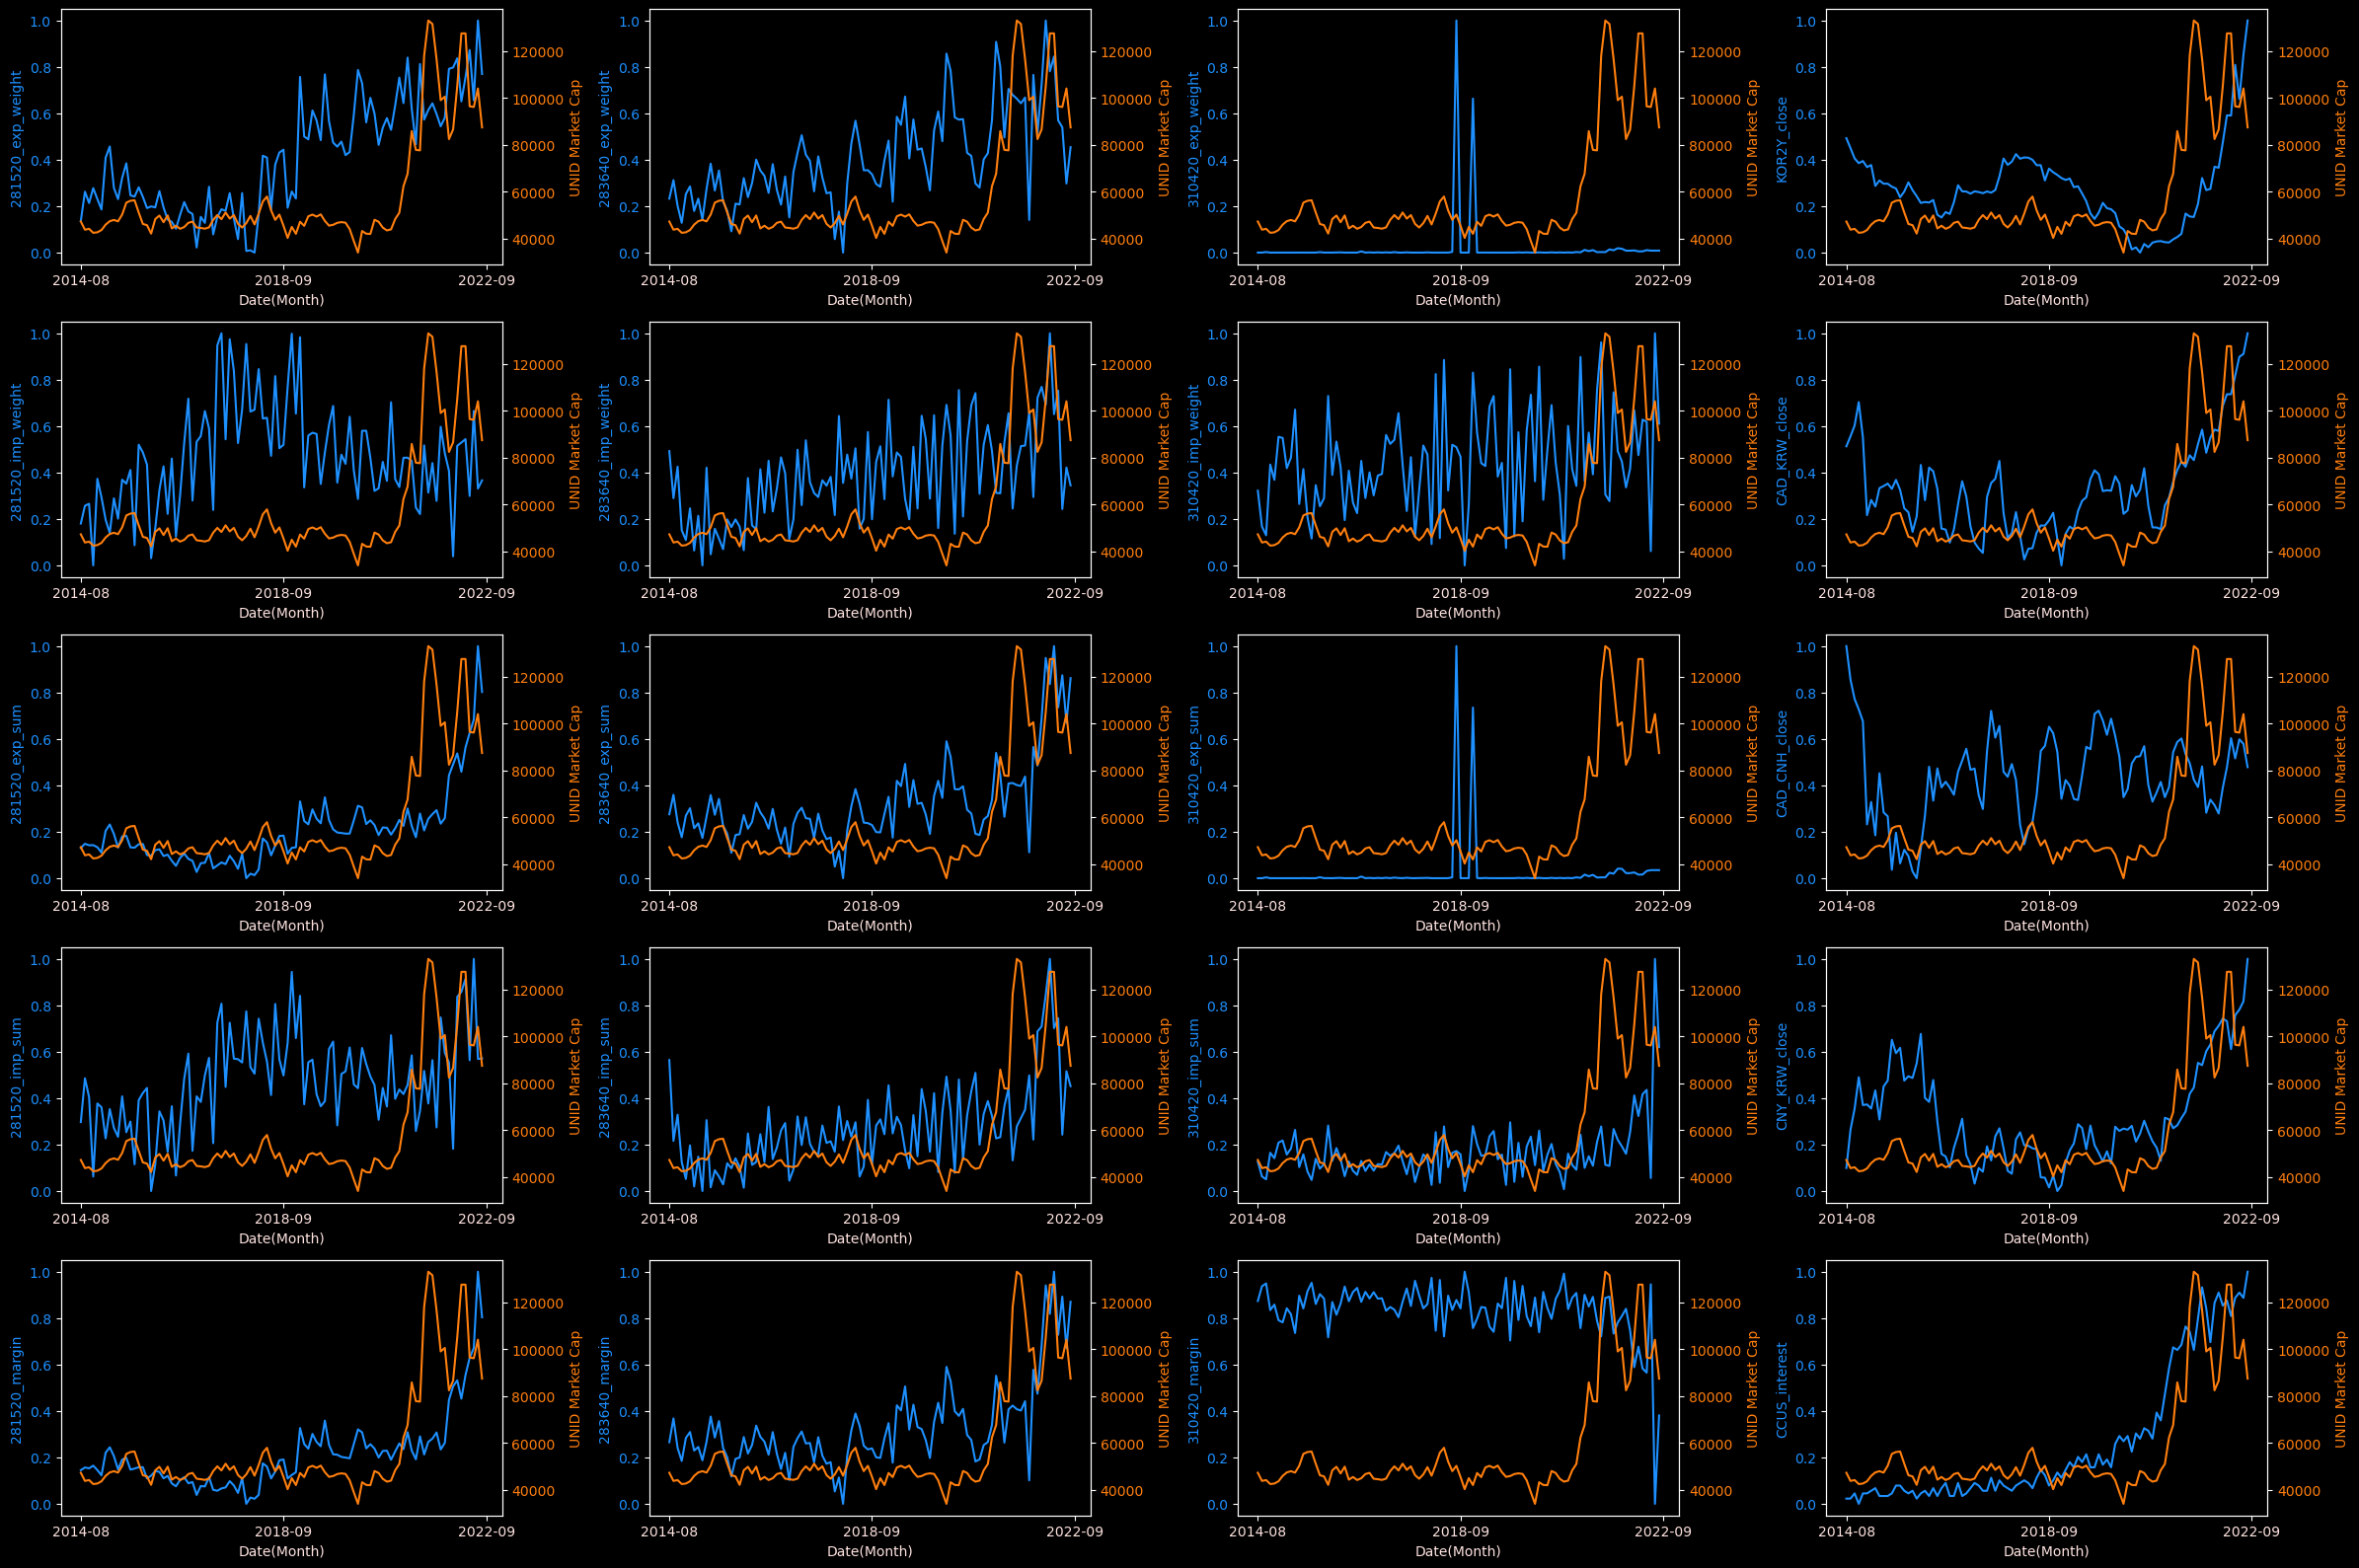

In [6]:
color_0, color_1, color_2, color_3 = 'mistyrose', 'dodgerblue', 'tab:orange', 'limegreen'  # darkmode : mistyrose, # lightmode : rosybrown
plt.figure(figsize=(24,16), facecolor='black')
for i in range(len(data.columns)-2) :
    from matplotlib import style
    style.use('dark_background')
    row, col = 5, 4
    r = i % row
    c = i // row
    #print(f'r : {r}, c : {c}, column = {data.columns[i]}, location : {(r*4)+(c+1)}')
    ax1 = plt.subplot(row, col, (r*4)+(c+1))
    plt.xticks([0, len(data.index)//2, len(data.index)], labels=[data.index[0], data.index[len(data.index)//2], data.index[-1]])
    ax1.set_xlabel('Date(Month)', color=color_0)
    ax1.tick_params(axis='x', labelcolor=color_0)
    ax1.set_ylabel(data.columns[i], color=color_1)
    ax1.plot(data.index, data.iloc[:,i], color=color_1, label=data.columns[i])
    ax1.tick_params(axis='y', labelcolor=color_1)
    ax2 = ax1.twinx()
    ax2.set_ylabel('UNID Market Cap', color=color_2)
    ax2.plot(data.index, data.iloc[:,-2], color=color_2, label='UNID Market Cap')
    ax2.tick_params(axis='y', labelcolor=color_2)
    #ax1.legend()
    #ax2.legend()
plt.tight_layout()
plt.show()

# 상관관계와 통계량 분석을 위한 SweetViz 자동화 EDA 툴 구동

In [7]:
sv.analyze(data, 'close').show_html(path + '/unid_report.html')

                                             |                                             | [  0%]   00:00 ->…

C:\Users\C.W Lee\anaconda3\lib\site-packages\sweetviz\graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
C:\Users\C.W Lee\anaconda3\lib\site-packages\sweetviz\graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
C:\Users\C.W Lee\anaconda3\lib\site-packages\sweetviz\graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
C:\Users\C.W Lee\anaconda3\lib\site-packages\sweetviz\graph_associations.py:223: FutureWarning: The frame.append metho

Report C:\Users\C.W Lee\OneDrive\FE/UNID/unid_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Row Base Predict with MLP

In [8]:
# Test with MLPRegressor
def MLP_Test(data):
    from sklearn.neural_network import MLPRegressor 
    from sklearn.metrics import mean_absolute_error
    from sklearn.model_selection import validation_curve
    import matplotlib.pyplot as plt
    from sklearn.model_selection import KFold
    np.random.seed(0)
    plt.style.use('ggplot')
    kf = KFold(n_splits=5)
    list_training_error = []
    list_testing_error = []
    
    X, y = np.array(data.iloc[:, :-2]), data.iloc[:, -1]
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = MLPRegressor(max_iter=10000)
        model.fit(X_train, y_train)
        y_train_data_pred = model.predict(X_train)
        y_test_data_pred = model.predict(X_test)
        fold_training_error = mean_absolute_error(y_train, y_train_data_pred) 
        fold_testing_error = mean_absolute_error(y_test, y_test_data_pred)
        list_training_error.append(fold_training_error)
        list_testing_error.append(fold_testing_error)
    print(f'list_training_error average : {np.mean(list_training_error)}, list_testing_error : {np.mean(list_testing_error)}')
MLP_Test(data)

list_training_error average : 0.1720115714327199, list_testing_error : 0.5650878090933532


# Predict with Time Series Model LSTM

In [9]:
seq_length = 3
n_layers = 2
batch = 1

train_size = int(len(data)*0.7)

### 종가를 스케일링하여 예측
data['close'] = scaler.fit_transform(np.array(data['close']).reshape(-1, 1) )
train_set = data[0:train_size].iloc[:, :-1]
data_dim = len(train_set.columns)
test_set = data[train_size-seq_length:].iloc[:, :-1]

# 설정값
hidden_dim = 64
output_dim = 1 
learning_rate = 0.001
nb_epochs = 300
sigmoid = nn.Sigmoid()

# ### 상을을 1로 하락은 0으로 예측 : 주가 미포함
# train_set = data.drop('close', axis=1)[0:train_size]
# data_dim = len(train_set.columns)
# test_set = data.drop('close', axis=1)[train_size-seq_length:]

# ### 상을을 1로 하락은 0으로 예측 : 주가 포함
# data['close'] = scaler.fit_transform(np.array(data['close']).reshape(-1, 1) )
# train_set = data[0:train_size]
# data_dim = len(train_set.columns)
# test_set = data[train_size-seq_length:]


# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset, batch_size=batch, shuffle=True, drop_last=True)

In [10]:
# Report maker 정의
def MAE(true, pred):
    return torch.mean(abs(true-pred))

def reportmaker(pred, testY_tensor = testY_tensor, test_set = test_set, testY = testY, seq_length = seq_length) :
    result = pd.DataFrame({'date' : list(test_set.index)[seq_length:], 'pred' : pred, 'true' : testY.squeeze()}).set_index('date')
    print('MAE SCORE : ', MAE(torch.FloatTensor(pred), testY_tensor))
    print(f"Mean : pred {result['pred'].mean()}, true {result['true'].mean()}")
    print(f"Std  : pred {result['pred'].std()}, true {result['true'].std()}")
    print(f"Var  : pred {result['pred'].var()}, true {result['true'].var()}")
    print(f"Min  : pred {result['pred'].min()}, true {result['true'].min()}")
    print(f"Max  : pred {result['pred'].max()}, true {result['true'].max()}")
    print(result)
    return result

# Plot maker 정의
def plotmaker(result):
    from matplotlib import style
    style.use('dark_background')
    fig = plt.figure(figsize=(12, 6))
    ax1 = plt.subplot()
    plt.xticks([0, len(result.index)//2, len(result.index)], labels=[result.index[0], result.index[len(result.index)//2], result.index[-1]])
    ax1.set_xlabel('Date(Month)', color=color_0)
    ax1.tick_params(axis='x', labelcolor=color_0)
    ax1.set_ylabel(result.columns[0], color=color_1)
    ax1.plot(result.index, result.iloc[:,0], color=color_1, label=result.columns[0])
    ax1.tick_params(axis='y', labelcolor=color_1)
    ax2 = ax1.twinx()
    ax2.set_ylabel(result.columns[1], color=color_2)
    ax2.plot(result.index, result.iloc[:,1], color=color_2, label=result.columns[1])
    ax2.tick_params(axis='y', labelcolor=color_2)
    plt.show()

In [11]:
class LSTM(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            #dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x
    
def train_model(model, train_df, num_epochs = None, lr = None):
     
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in tqdm(range(nb_epochs)):
        avg_cost = 0
        total_batch = len(train_df)
        #print(epoch)
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            x_train, y_train = x_train.to(device), y_train.to(device)
            
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
            #print(outputs)
                
            # cost 계산
            loss = criterion(outputs, y_train)
            #print(f'loss : {loss}, ouputs : {outputs.item()}, y_train : {y_train.item()}')
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
                        
    return model.eval(), train_hist

In [12]:
# 모델 학습
net = LSTM(data_dim, hidden_dim, seq_length, output_dim, layers = n_layers).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0000 train loss : 0.0065
Epoch: 0001 train loss : 0.0019
Epoch: 0002 train loss : 0.0019
Epoch: 0003 train loss : 0.0018
Epoch: 0004 train loss : 0.0016
Epoch: 0005 train loss : 0.0013
Epoch: 0006 train loss : 0.0018
Epoch: 0007 train loss : 0.0013
Epoch: 0008 train loss : 0.0012
Epoch: 0009 train loss : 0.0013
Epoch: 0010 train loss : 0.0014
Epoch: 0011 train loss : 0.0011
Epoch: 0012 train loss : 0.0012
Epoch: 0013 train loss : 0.0012
Epoch: 0014 train loss : 0.0013
Epoch: 0015 train loss : 0.0011
Epoch: 0016 train loss : 0.0011
Epoch: 0017 train loss : 0.0011
Epoch: 0018 train loss : 0.0011
Epoch: 0019 train loss : 0.0009
Epoch: 0020 train loss : 0.0010
Epoch: 0021 train loss : 0.0010
Epoch: 0022 train loss : 0.0009
Epoch: 0023 train loss : 0.0008
Epoch: 0024 train loss : 0.0008
Epoch: 0025 train loss : 0.0008
Epoch: 0026 train loss : 0.0008
Epoch: 0027 train loss : 0.0008
Epoch: 0028 train loss : 0.0008
Epoch: 0029 train loss : 0.0008
Epoch: 0030 train loss : 0.0008
Epoch: 0

Epoch: 0258 train loss : 0.0000
Epoch: 0259 train loss : 0.0000
Epoch: 0260 train loss : 0.0001
Epoch: 0261 train loss : 0.0001
Epoch: 0262 train loss : 0.0001
Epoch: 0263 train loss : 0.0000
Epoch: 0264 train loss : 0.0000
Epoch: 0265 train loss : 0.0000
Epoch: 0266 train loss : 0.0000
Epoch: 0267 train loss : 0.0000
Epoch: 0268 train loss : 0.0000
Epoch: 0269 train loss : 0.0000
Epoch: 0270 train loss : 0.0000
Epoch: 0271 train loss : 0.0000
Epoch: 0272 train loss : 0.0000
Epoch: 0273 train loss : 0.0000
Epoch: 0274 train loss : 0.0000
Epoch: 0275 train loss : 0.0000
Epoch: 0276 train loss : 0.0000
Epoch: 0277 train loss : 0.0000
Epoch: 0278 train loss : 0.0001
Epoch: 0279 train loss : 0.0000
Epoch: 0280 train loss : 0.0001
Epoch: 0281 train loss : 0.0002
Epoch: 0282 train loss : 0.0001
Epoch: 0283 train loss : 0.0000
Epoch: 0284 train loss : 0.0000
Epoch: 0285 train loss : 0.0000
Epoch: 0286 train loss : 0.0000
Epoch: 0287 train loss : 0.0000
Epoch: 0288 train loss : 0.0000
Epoch: 0

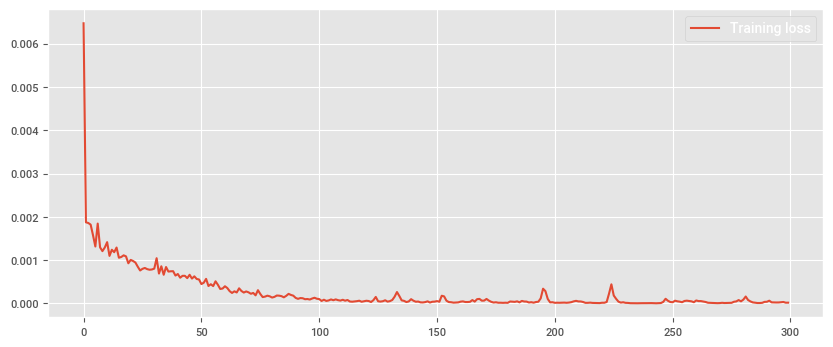

In [13]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [14]:
# 모델 저장    
PATH = path + "/models/UNID_LSTM_Target-Close.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = LSTM(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)

# 예측 테스트
model.eval()
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr].to(device), 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

In [15]:
result = reportmaker(pred)

MAE SCORE :  tensor(0.4248)
Mean : pred 0.05494631913801034, true 0.4767845117845119
Std  : pred 0.05746925295036476, true 0.31336803232332944
Var  : pred 0.0033027150346730087, true 0.09819952368219523
Min  : pred -0.06851248443126678, true 0.08030303030303032
Max  : pred 0.15194737911224365, true 1.0
             pred      true
date                       
2020-04  0.139256  0.092929
2020-05  0.119557  0.081313
2020-06  0.087415  0.080303
2020-07  0.095240  0.141414
2020-08  0.089237  0.132828
2020-09  0.078568  0.107576
2020-10  0.078776  0.095455
2020-11  0.070285  0.100000
2020-12  0.057415  0.144444
2021-01  0.071943  0.171717
2021-02  0.081354  0.285859
2021-03  0.073507  0.339394
2021-04  0.076755  0.523232
2021-05  0.030954  0.442424
2021-06  0.031521  0.440404
2021-07  0.075124  0.848485
2021-08 -0.019913  1.000000
2021-09 -0.040417  0.984848
2021-10 -0.034608  0.833333
2021-11  0.001749  0.656566
2021-12 -0.001603  0.671717
2022-01  0.010790  0.488889
2022-02  0.106532  0.530

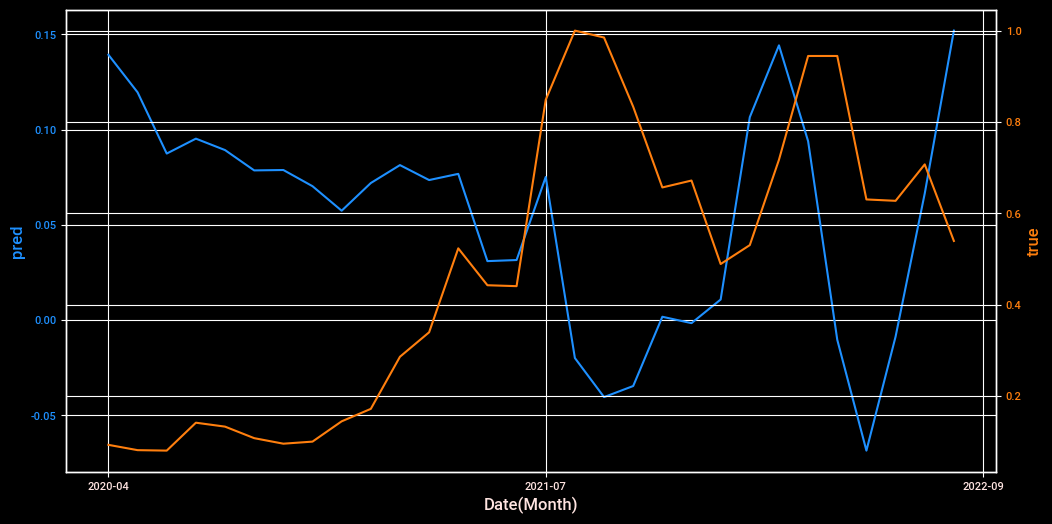

In [16]:
plotmaker(result)

In [17]:
'''
데이터셋 : 전체
예측대상 : 종가
분석결과 : 예측값과 실제값의 MAE는 0.4983, 예측값의 분산은 0.004, 실제값의 분산은 0.09 이나, 플롯을 보면 예측값의 plot이 실제값의 plot을 후행하는 경향을 보임
다음스텝 : 종가가 아닌 '상승', '하락'을 예측, 그 다음은 학습 컬럼을 축소(수출원소의 수입컬럼 제외, 수입원소의 수출컬럼 제외)
'''

"\n데이터셋 : 전체\n예측대상 : 종가\n분석결과 : 예측값과 실제값의 MAE는 0.4983, 예측값의 분산은 0.004, 실제값의 분산은 0.09 이나, 플롯을 보면 예측값의 plot이 실제값의 plot을 후행하는 경향을 보임\n다음스텝 : 종가가 아닌 '상승', '하락'을 예측, 그 다음은 학습 컬럼을 축소(수출원소의 수입컬럼 제외, 수입원소의 수출컬럼 제외)\n"

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0000 train loss : 0.3084
Epoch: 0001 train loss : 0.2604
Epoch: 0002 train loss : 0.2606
Epoch: 0003 train loss : 0.2556
Epoch: 0004 train loss : 0.2543
Epoch: 0005 train loss : 0.2654
Epoch: 0006 train loss : 0.2492
Epoch: 0007 train loss : 0.2567
Epoch: 0008 train loss : 0.2505
Epoch: 0009 train loss : 0.2448
Epoch: 0010 train loss : 0.2425
Epoch: 0011 train loss : 0.2844
Epoch: 0012 train loss : 0.2611
Epoch: 0013 train loss : 0.2426
Epoch: 0014 train loss : 0.2552
Epoch: 0015 train loss : 0.2333
Epoch: 0016 train loss : 0.2405
Epoch: 0017 train loss : 0.2232
Epoch: 0018 train loss : 0.2199
Epoch: 0019 train loss : 0.2327
Epoch: 0020 train loss : 0.2337
Epoch: 0021 train loss : 0.2213
Epoch: 0022 train loss : 0.2188
Epoch: 0023 train loss : 0.1932
Epoch: 0024 train loss : 0.1913
Epoch: 0025 train loss : 0.1843
Epoch: 0026 train loss : 0.1814
Epoch: 0027 train loss : 0.1745
Epoch: 0028 train loss : 0.1685
Epoch: 0029 train loss : 0.1784
Epoch: 0030 train loss : 0.1721
Epoch: 0

Epoch: 0258 train loss : 0.0000
Epoch: 0259 train loss : 0.0000
Epoch: 0260 train loss : 0.0000
Epoch: 0261 train loss : 0.0000
Epoch: 0262 train loss : 0.0000
Epoch: 0263 train loss : 0.0000
Epoch: 0264 train loss : 0.0001
Epoch: 0265 train loss : 0.0001
Epoch: 0266 train loss : 0.0001
Epoch: 0267 train loss : 0.0001
Epoch: 0268 train loss : 0.0001
Epoch: 0269 train loss : 0.0003
Epoch: 0270 train loss : 0.0006
Epoch: 0271 train loss : 0.0009
Epoch: 0272 train loss : 0.0012
Epoch: 0273 train loss : 0.0013
Epoch: 0274 train loss : 0.0013
Epoch: 0275 train loss : 0.0012
Epoch: 0276 train loss : 0.0005
Epoch: 0277 train loss : 0.0003
Epoch: 0278 train loss : 0.0002
Epoch: 0279 train loss : 0.0002
Epoch: 0280 train loss : 0.0001
Epoch: 0281 train loss : 0.0001
Epoch: 0282 train loss : 0.0002
Epoch: 0283 train loss : 0.0002
Epoch: 0284 train loss : 0.0002
Epoch: 0285 train loss : 0.0003
Epoch: 0286 train loss : 0.0005
Epoch: 0287 train loss : 0.0003
Epoch: 0288 train loss : 0.0003
Epoch: 0

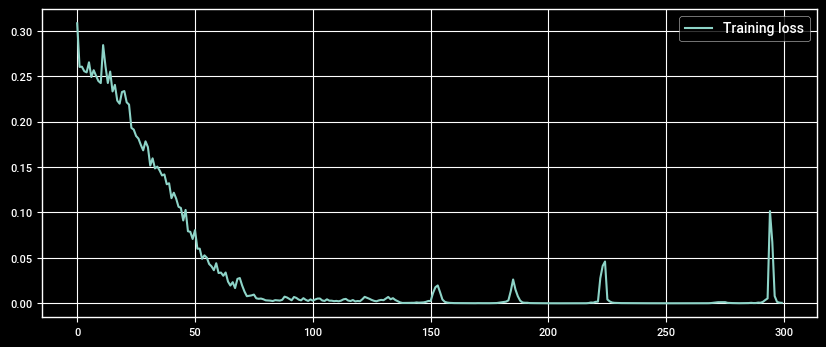

In [18]:
### 상을을 1로 하락은 0으로 예측 : 주가 포함
data['close'] = scaler.fit_transform(np.array(data['close']).reshape(-1, 1) )
train_set = data[0:train_size]
data_dim = len(train_set.columns)
test_set = data[train_size-seq_length:]

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset, batch_size=batch, shuffle=True, drop_last=True)

# 모델 학습
net = LSTM(data_dim, hidden_dim, seq_length, output_dim, 2).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate)

# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [19]:
# 모델 저장    
PATH = path + "/models/UNID_LSTM_Target-UpAndDown.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = LSTM(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)

# 예측 테스트
model.eval()
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr].to(device), 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

In [20]:
result = reportmaker(pred, testY_tensor = testY_tensor, test_set = test_set, testY = testY, seq_length = seq_length)

MAE SCORE :  tensor(0.4833)
Mean : pred 0.1973660166064898, true 0.48333333333333334
Std  : pred 0.08816299137959048, true 0.499712561057015
Var  : pred 0.0077727130489977465, true 0.24971264367816093
Min  : pred 0.05254313349723816, true 0.0
Max  : pred 0.4200875759124756, true 1.0
             pred  true
date                   
2020-04  0.107057   0.0
2020-05  0.250347   0.0
2020-06  0.230805   1.0
2020-07  0.155732   0.0
2020-08  0.303028   0.0
2020-09  0.179132   0.0
2020-10  0.101926   1.0
2020-11  0.078439   1.0
2020-12  0.222273   1.0
2021-01  0.265134   1.0
2021-02  0.249796   1.0
2021-03  0.210846   1.0
2021-04  0.266031   0.0
2021-05  0.149178   0.0
2021-06  0.081903   1.0
2021-07  0.189765   1.0
2021-08  0.420088   0.0
2021-09  0.104394   0.0
2021-10  0.179878   0.0
2021-11  0.204095   1.0
2021-12  0.296180   0.0
2022-01  0.199610   1.0
2022-02  0.150018   1.0
2022-03  0.395360   1.0
2022-04  0.238034   0.0
2022-05  0.052543   0.0
2022-06  0.116702   0.0
2022-07  0.187454   

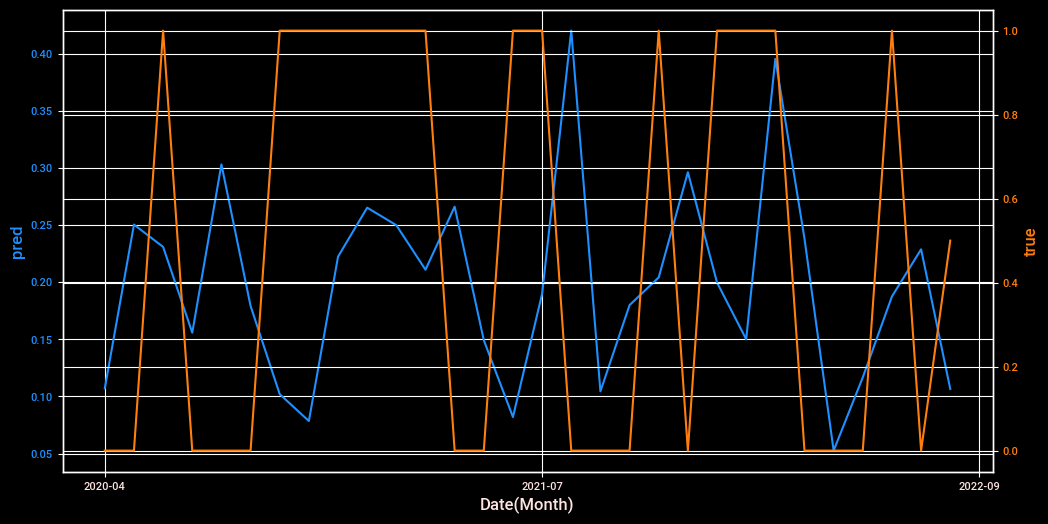

In [21]:
plotmaker(result)

In [22]:
'''
데이터셋 : 전체
예측대상 : 상승, 하락
분석결과 : 예측값과 실제값의 MAE는 0.5697, 예측값의 분산은 0.014, 실제값의 분산은 0.25, 예측값의 중앙값을 기준으로 상승, 하락을 예측하면 정확도가 높은 편이나 0.5가 아닌 중앙값을 기준으로 판단해야 하는 위험이 있음
다음스텝 : 학습 컬럼을 축소(수출원소의 수입컬럼 제외, 수입원소의 수출컬럼 제외)
'''

'\n데이터셋 : 전체\n예측대상 : 상승, 하락\n분석결과 : 예측값과 실제값의 MAE는 0.5697, 예측값의 분산은 0.014, 실제값의 분산은 0.25, 예측값의 중앙값을 기준으로 상승, 하락을 예측하면 정확도가 높은 편이나 0.5가 아닌 중앙값을 기준으로 판단해야 하는 위험이 있음\n다음스텝 : 학습 컬럼을 축소(수출원소의 수입컬럼 제외, 수입원소의 수출컬럼 제외)\n'

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0000 train loss : 0.3111
Epoch: 0001 train loss : 0.2600
Epoch: 0002 train loss : 0.2536
Epoch: 0003 train loss : 0.2417
Epoch: 0004 train loss : 0.2579
Epoch: 0005 train loss : 0.2603
Epoch: 0006 train loss : 0.2521
Epoch: 0007 train loss : 0.2453
Epoch: 0008 train loss : 0.2422
Epoch: 0009 train loss : 0.2343
Epoch: 0010 train loss : 0.2345
Epoch: 0011 train loss : 0.2389
Epoch: 0012 train loss : 0.2438
Epoch: 0013 train loss : 0.2388
Epoch: 0014 train loss : 0.2287
Epoch: 0015 train loss : 0.2241
Epoch: 0016 train loss : 0.2257
Epoch: 0017 train loss : 0.2184
Epoch: 0018 train loss : 0.2306
Epoch: 0019 train loss : 0.2222
Epoch: 0020 train loss : 0.2132
Epoch: 0021 train loss : 0.2190
Epoch: 0022 train loss : 0.2215
Epoch: 0023 train loss : 0.2207
Epoch: 0024 train loss : 0.2133
Epoch: 0025 train loss : 0.2093
Epoch: 0026 train loss : 0.2156
Epoch: 0027 train loss : 0.2152
Epoch: 0028 train loss : 0.2084
Epoch: 0029 train loss : 0.2153
Epoch: 0030 train loss : 0.2035
Epoch: 0

Epoch: 0258 train loss : 0.0001
Epoch: 0259 train loss : 0.0001
Epoch: 0260 train loss : 0.0001
Epoch: 0261 train loss : 0.0000
Epoch: 0262 train loss : 0.0000
Epoch: 0263 train loss : 0.0000
Epoch: 0264 train loss : 0.0000
Epoch: 0265 train loss : 0.0000
Epoch: 0266 train loss : 0.0000
Epoch: 0267 train loss : 0.0000
Epoch: 0268 train loss : 0.0000
Epoch: 0269 train loss : 0.0000
Epoch: 0270 train loss : 0.0001
Epoch: 0271 train loss : 0.0001
Epoch: 0272 train loss : 0.0002
Epoch: 0273 train loss : 0.0003
Epoch: 0274 train loss : 0.0006
Epoch: 0275 train loss : 0.0009
Epoch: 0276 train loss : 0.0011
Epoch: 0277 train loss : 0.0039
Epoch: 0278 train loss : 0.0069
Epoch: 0279 train loss : 0.0408
Epoch: 0280 train loss : 0.0216
Epoch: 0281 train loss : 0.0051
Epoch: 0282 train loss : 0.0045
Epoch: 0283 train loss : 0.0010
Epoch: 0284 train loss : 0.0007
Epoch: 0285 train loss : 0.0003
Epoch: 0286 train loss : 0.0002
Epoch: 0287 train loss : 0.0001
Epoch: 0288 train loss : 0.0001
Epoch: 0

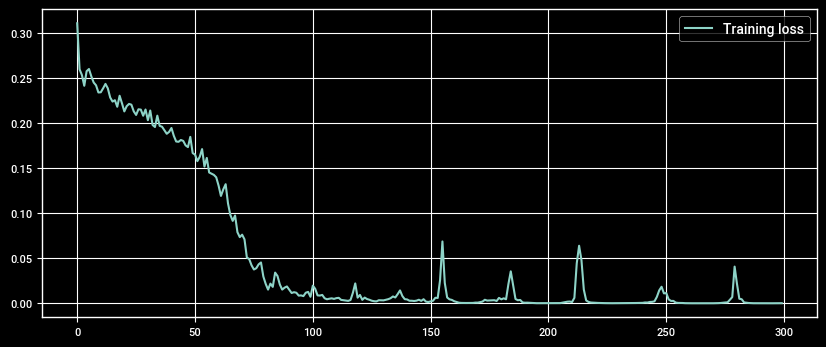

In [23]:
adj_data = data.drop(['281520_imp_weight', '281520_imp_sum', '283640_imp_weight', '283640_imp_sum', '310420_exp_weight' ,'310420_exp_sum'], axis=1)
### 상을을 1로 하락은 0으로 예측 : 주가 포함
train_set = adj_data[0:train_size]
data_dim = len(train_set.columns)
test_set = adj_data[train_size-seq_length:]

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset, batch_size=batch, shuffle=True, drop_last=True)

# 모델 학습
net = LSTM(data_dim, hidden_dim, seq_length, output_dim, 2).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate)

# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [24]:
# 모델 저장    
PATH = path + "/models/UNID_LSTM_adj-data_Target-UpAndDown.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = LSTM(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)

# 예측 테스트
model.eval()
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr].to(device), 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

In [25]:
result = reportmaker(pred, testY_tensor = testY_tensor, test_set = test_set, testY = testY, seq_length = seq_length)

MAE SCORE :  tensor(0.4833)
Mean : pred 0.19589465210835139, true 0.48333333333333334
Std  : pred 0.09605078036684651, true 0.499712561057015
Var  : pred 0.009225752409080187, true 0.24971264367816093
Min  : pred 0.0016738176345825195, true 0.0
Max  : pred 0.3682265877723694, true 1.0
             pred  true
date                   
2020-04  0.073501   0.0
2020-05  0.121566   0.0
2020-06  0.210122   1.0
2020-07  0.058860   0.0
2020-08  0.105922   0.0
2020-09  0.229899   0.0
2020-10  0.080385   1.0
2020-11  0.001674   1.0
2020-12  0.155906   1.0
2021-01  0.368227   1.0
2021-02  0.311480   1.0
2021-03  0.354676   1.0
2021-04  0.317273   0.0
2021-05  0.229655   0.0
2021-06  0.240993   1.0
2021-07  0.159797   1.0
2021-08  0.326440   0.0
2021-09  0.229073   0.0
2021-10  0.168721   0.0
2021-11  0.187718   1.0
2021-12  0.229181   0.0
2022-01  0.343275   1.0
2022-02  0.144531   1.0
2022-03  0.222098   1.0
2022-04  0.281212   0.0
2022-05  0.220922   0.0
2022-06  0.126755   0.0
2022-07  0.085200 

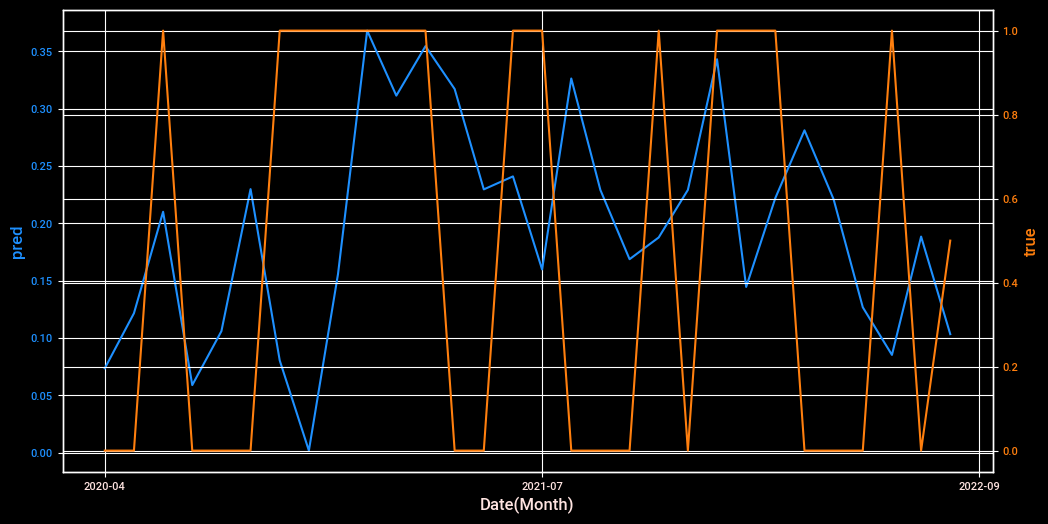

In [26]:
plotmaker(result)

In [27]:
'''
데이터셋 : 탄산/가성칼륨 수입, 염화칼륨 수출 제외
예측대상 : 상승, 하락
분석결과 : 유니드 손익에 관계가 적은 컬럼을 제거하여 예측값 정확도 향상을 기대했으나, 전반적으로 0에 더 가까워짐
다음스텝 : 어텐션 도입
'''

'\n데이터셋 : 탄산/가성칼륨 수입, 염화칼륨 수출 제외\n예측대상 : 상승, 하락\n분석결과 : 유니드 손익에 관계가 적은 컬럼을 제거하여 예측값 정확도 향상을 기대했으나, 전반적으로 0에 더 가까워짐\n다음스텝 : 어텐션 도입\n'

# DA-RNN

In [28]:
class encoder(nn.Module):
    def __init__(self, input_size, hidden_size, T):
        # input size: number of underlying factors (81)
        # T: number of time steps (10)
        # hidden_size: dimension of the hidden state
        super(encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.T = T

        self.lstm_layer = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1)
        self.attn_linear = nn.Linear(in_features = 2 * hidden_size + T - 1, out_features = 1)

    def forward(self, input_data):
        # input_data: batch_size * T - 1 * input_size        
        input_weighted = Variable(input_data.data.new(input_data.size(0), self.T - 1, self.input_size).zero_())
        input_encoded = Variable(input_data.data.new(input_data.size(0), self.T - 1, self.hidden_size).zero_())
        # hidden, cell: initial states with dimention hidden_size
        hidden = self.init_hidden(input_data) # 1 * batch_size * hidden_size
        cell = self.init_hidden(input_data)
        # hidden.requires_grad = False
        # cell.requires_grad = False
        for t in range(self.T - 1):
            # Eqn. 8: concatenate the hidden states with each predictor
            x = torch.cat((hidden.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           input_data.permute(0, 2, 1)), dim = 2) # batch_size * input_size * (2*hidden_size + T - 1)
            # Eqn. 9: Get attention weights
            x = self.attn_linear(x.view(-1, self.hidden_size * 2 + self.T - 1)) # (batch_size * input_size) * 1
            attn_weights = F.softmax(x.view(-1, self.input_size)) # batch_size * input_size, attn weights with values sum up to 1.
            # Eqn. 10: LSTM
            weighted_input = torch.mul(attn_weights, input_data[:, t, :]) # batch_size * input_size
            # Fix the warning about non-contiguous memory
            # see https://discuss.pytorch.org/t/dataparallel-issue-with-flatten-parameter/8282
            self.lstm_layer.flatten_parameters()
            _, lstm_states = self.lstm_layer(weighted_input.unsqueeze(0), (hidden, cell))
            hidden = lstm_states[0]
            cell = lstm_states[1]
            # Save output
            input_weighted[:, t, :] = weighted_input
            input_encoded[:, t, :] = hidden
        return input_weighted, input_encoded

    def init_hidden(self, x):
        # No matter whether CUDA is used, the returned variable will have the same type as x.
        return Variable(x.data.new(1, x.size(0), self.hidden_size).zero_()) # dimension 0 is the batch dimension

class decoder(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size, T):
        super(decoder, self).__init__()

        self.T = T
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size

        self.attn_layer = nn.Sequential(nn.Linear(2 * decoder_hidden_size + encoder_hidden_size, encoder_hidden_size),
                                         nn.Tanh(), nn.Linear(encoder_hidden_size, 1))
        self.lstm_layer = nn.LSTM(input_size = 1, hidden_size = decoder_hidden_size)
        self.fc = nn.Linear(encoder_hidden_size + 1, 1)
        self.fc_final = nn.Linear(decoder_hidden_size + encoder_hidden_size, 1)

        self.fc.weight.data.normal_()

    def forward(self, input_encoded, y_history):
        # input_encoded: batch_size * T - 1 * encoder_hidden_size
        # y_history: batch_size * (T-1)
        # Initialize hidden and cell, 1 * batch_size * decoder_hidden_size
        hidden = self.init_hidden(input_encoded)
        cell = self.init_hidden(input_encoded)
        # hidden.requires_grad = False
        # cell.requires_grad = False
        for t in range(self.T - 1):
            # Eqn. 12-13: compute attention weights
            ## batch_size * T * (2*decoder_hidden_size + encoder_hidden_size)
            x = torch.cat((hidden.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.T - 1, 1, 1).permute(1, 0, 2), input_encoded), dim = 2)
            x = F.softmax(self.attn_layer(x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size
                                                )).view(-1, self.T - 1)) # batch_size * T - 1, row sum up to 1
            # Eqn. 14: compute context vector
            context = torch.bmm(x.unsqueeze(1), input_encoded)[:, 0, :] # batch_size * encoder_hidden_size
            if t < self.T - 1:
                # Eqn. 15
                y_tilde = self.fc(torch.cat((context, y_history[:, t].unsqueeze(1)), dim = 1)) # batch_size * 1
                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, lstm_output = self.lstm_layer(y_tilde.unsqueeze(0), (hidden, cell))
                hidden = lstm_output[0] # 1 * batch_size * decoder_hidden_size
                cell = lstm_output[1] # 1 * batch_size * decoder_hidden_size
        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((hidden[0], context), dim = 1))
        return y_pred

    def init_hidden(self, x):
        return Variable(x.data.new(1, x.size(0), self.decoder_hidden_size).zero_())
    
# Train the model
class da_rnn(nn.Module):
    def __init__(self, file_data, target, encoder_hidden_size = 64, decoder_hidden_size = 64, T = 10,
                 learning_rate = 0.01, batch_size = 128, parallel = True, debug = False):
        super(da_rnn, self).__init__()
        self.T = T
        dat = file_data

        self.X = np.array(dat.loc[:, :'CCUS_interest'])
        self.y = np.array(dat.loc[:, target])  # 주가 예측시
        self.batch_size = batch_size

        self.encoder = encoder(input_size = self.X.shape[1], hidden_size = encoder_hidden_size, T = T).to(device)
        self.decoder = decoder(encoder_hidden_size = encoder_hidden_size,
                               decoder_hidden_size = decoder_hidden_size,
                               T = T).to(device)

        if parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, self.encoder.parameters()),
                                           lr = learning_rate)
        self.decoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, self.decoder.parameters()),
                                           lr = learning_rate)
        # self.learning_rate = learning_rate

        self.train_size = int(self.X.shape[0] * 0.7)
        self.y = self.y - np.mean(self.y[:self.train_size]) # Question: why Adam requires data to be normalized?

    def train(self, n_epochs = 10):
        iter_per_epoch = int(np.ceil(self.train_size * 1. / self.batch_size))
        self.iter_losses = np.zeros(n_epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(n_epochs)

        self.loss_func = nn.MSELoss()

        n_iter = 0

        learning_rate = 1.

        for i in tqdm(range(n_epochs)):
            perm_idx = np.random.permutation(self.train_size - self.T)
            j = 0
            while j < self.train_size:
                batch_idx = perm_idx[j:(j + self.batch_size)]
                X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
                y_history = np.zeros((len(batch_idx), self.T - 1))
                y_target = self.y[batch_idx + self.T]

                for k in range(len(batch_idx)):
                    X[k, :, :] = self.X[batch_idx[k] : (batch_idx[k] + self.T - 1), :]
                    y_history[k, :] = self.y[batch_idx[k] : (batch_idx[k] + self.T - 1)]

                loss = self.train_iteration(X, y_history, y_target)
                self.iter_losses[i * iter_per_epoch + j // self.batch_size] = loss
                j += self.batch_size
                n_iter += 1

                if n_iter % 10000 == 0 and n_iter > 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9

            self.epoch_losses[i] = np.mean(self.iter_losses[range(i * iter_per_epoch, (i + 1) * iter_per_epoch)])

            if i % 10 == 0:
                print(f"epoch : {i}, n_iter : {n_iter}, lr : {self.encoder_optimizer.param_groups[0]['lr']}, loss : {loss}")
                y_train_pred = self.predict(on_train = True)
                y_test_pred = self.predict(on_train = False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label = "True")
                plt.plot(range(self.T , len(y_train_pred) + self.T), y_train_pred, label = 'Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred) , len(self.y) + 1), y_test_pred, label = 'Predicted - Test')
                plt.legend(loc = 'upper left')
                plt.show()
                print('-'*50)

    def train_iteration(self, X, y_history, y_target):
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_weighted, input_encoded = self.encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor).to(device)))
        y_pred = self.decoder(input_encoded, Variable(torch.from_numpy(y_history).type(torch.FloatTensor).to(device)))

        y_true = Variable(torch.from_numpy(y_target).type(torch.FloatTensor).to(device))
        loss = self.loss_func(y_pred, y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item()

    def predict(self, on_train = False):
        if on_train:
            y_pred = np.zeros(self.train_size - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_size)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i : (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))
            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(batch_idx[j],  batch_idx[j]+ self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(batch_idx[j] + self.train_size - self.T, batch_idx[j] + self.train_size - 1), :]
                    y_history[j, :] = self.y[range(batch_idx[j] + self.train_size - self.T,  batch_idx[j]+ self.train_size - 1)]

            y_history = Variable(torch.from_numpy(y_history).type(torch.FloatTensor).to(device))
            _, input_encoded = self.encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor).to(device)))
            y_pred[i:(i + self.batch_size)] = self.decoder(input_encoded, y_history).cpu().data.numpy()[:, 0]
            i += self.batch_size
        return y_pred

In [ ]:
task = 'tgt'
model = da_rnn(file_data = adj_data, target = task, parallel = False, learning_rate = learning_rate, batch_size=batch)  # target = close or tgt
model.train(n_epochs = 2000)
PATH = path + f"/models/UNID_DARNN_adj-data_Target-{task}.pth"
torch.save(model.state_dict(), PATH)

adj_y_pred_tgt = model.predict()
adj_y_true_tgt = model.y[model.train_size:]

plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.show()

plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.show()

plt.figure()
plt.plot(adj_y_pred_tgt, label = 'Predicted')
plt.plot(model.y[model.train_size:], label = "True")
plt.legend(loc = 'upper left')
plt.show()

MAE :  0.256130290506225


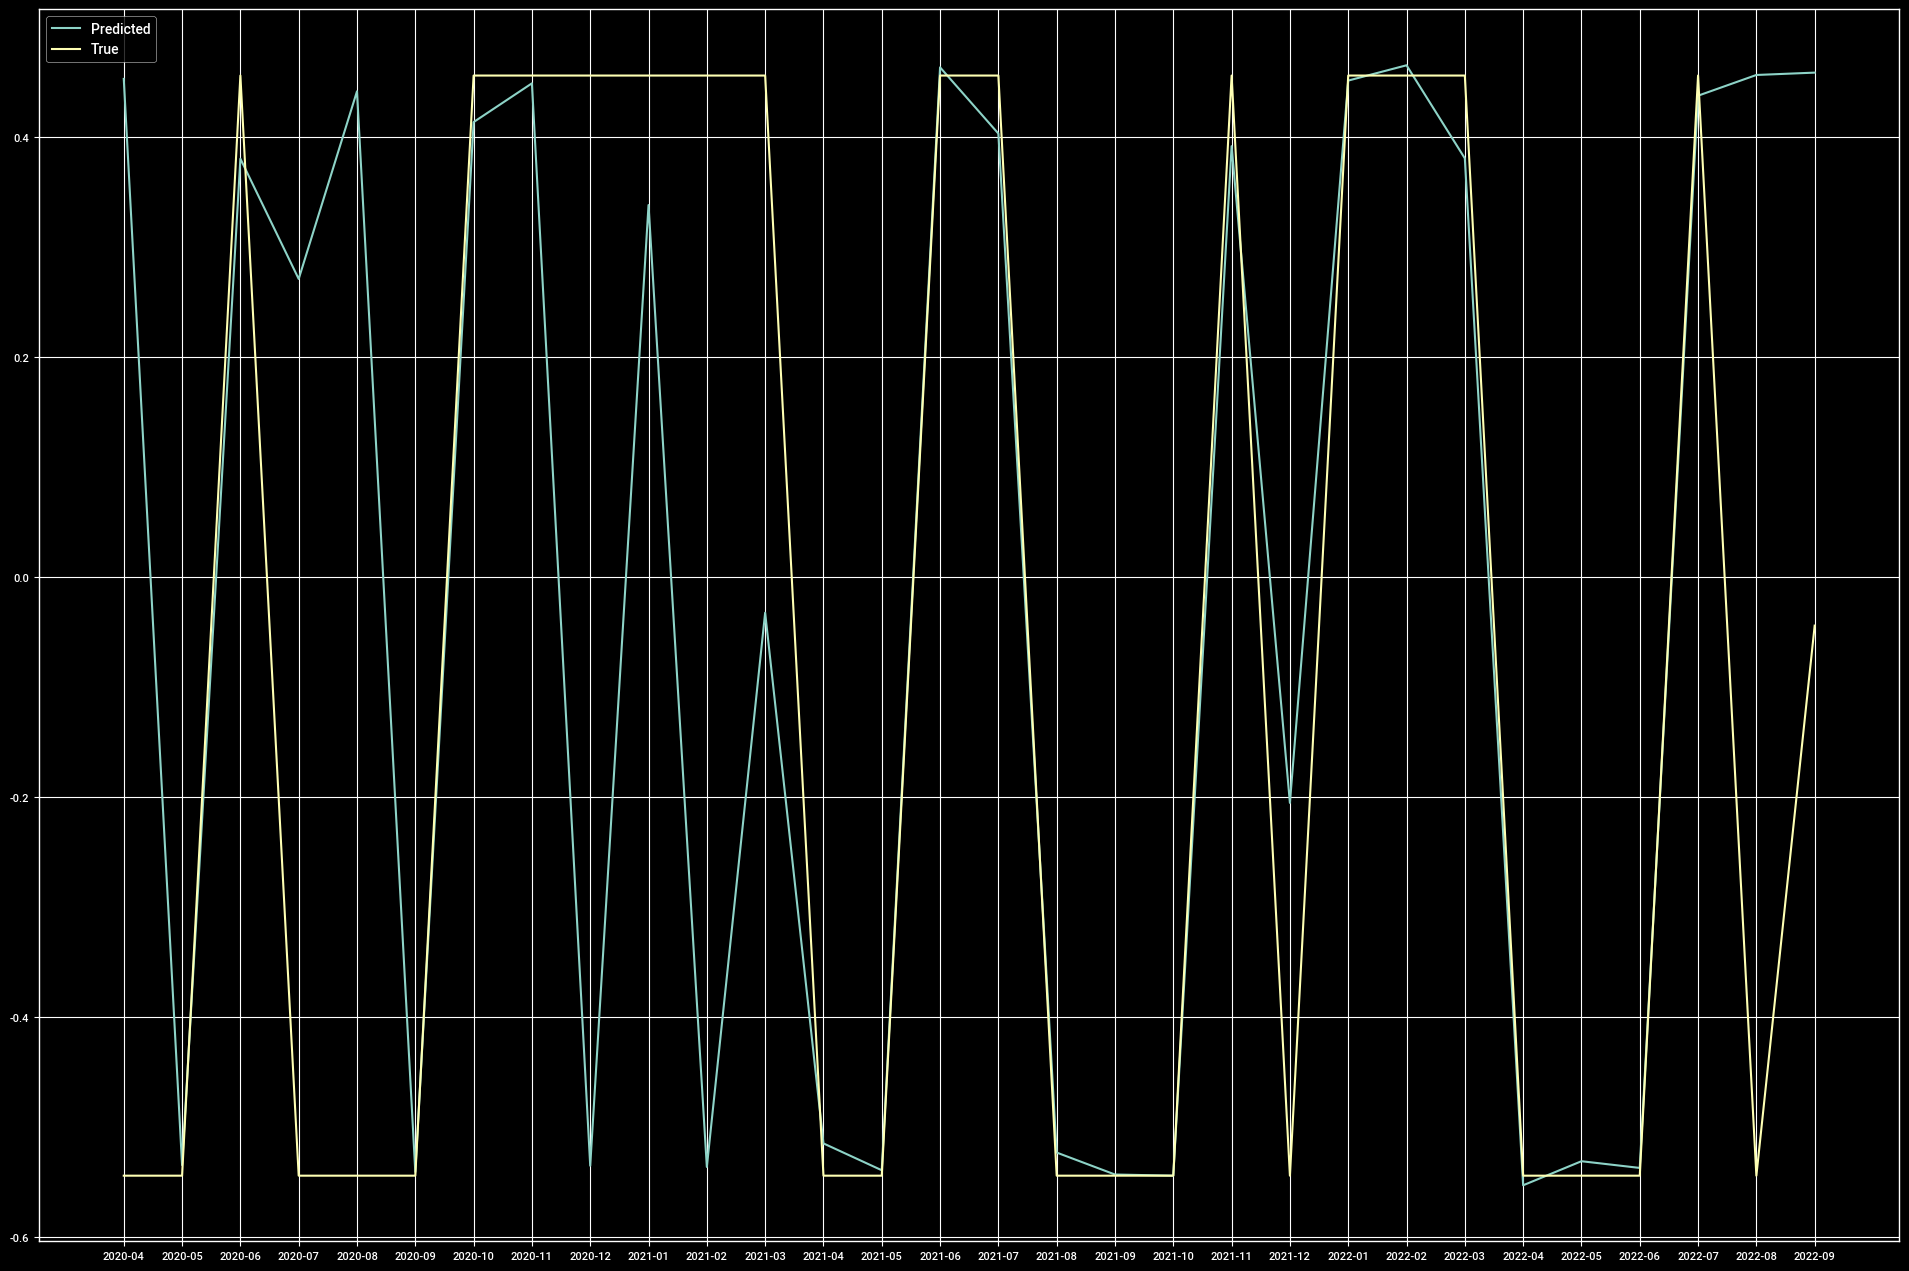

,pred,true,ae
date,,,
2020-04,0.452834,-0.544118,0.996952
2020-05,-0.534502,-0.544118,0.009616
2020-06,0.380291,0.455882,0.075591
2020-07,0.270991,-0.544118,0.815109
2020-08,0.441570,-0.544118,0.985687
2020-09,-0.540688,-0.544118,0.003430
2020-10,0.413566,0.455882,0.042316
2020-11,0.448807,0.455882,0.007076
2020-12,-0.535084,0.455882,0.990966


In [39]:
adj_df_tgt = pd.DataFrame({
    'date' : list(adj_data.index[model.train_size:]),
    'pred' : adj_y_pred_tgt,
    'true' : adj_y_true_tgt,
    'ae' : abs(adj_y_pred_tgt - adj_y_true_tgt)
}).set_index('date')
print('MAE : ', np.mean(adj_df_tgt['ae']))

plt.figure(figsize=(24,16), facecolor='black')
style.use('dark_background')
plt.plot(adj_df_tgt['pred'], label = 'Predicted')
plt.plot(adj_df_tgt['true'], label = "True")
plt.legend(loc = 'upper left')
plt.show()

adj_df_tgt

In [ ]:
task = 'close'
model = da_rnn(file_data = adj_data, target = task, parallel = False, learning_rate = learning_rate, batch_size=batch)  # target = close or tgt
model.train(n_epochs = 2000)
PATH = path + f"/models/UNID_DARNN_adj-data_Target-{task}.pth"
torch.save(model.state_dict(), PATH)

adj_y_pred_close = model.predict()
adj_y_true_close = model.y[model.train_size:]

plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.show()

plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.show()

plt.figure()
plt.plot(adj_y_pred_close, label = 'Predicted')
plt.plot(model.y[model.train_size:], label = "True")
plt.legend(loc = 'upper left')
plt.show()

MAE :  0.5060894546033301


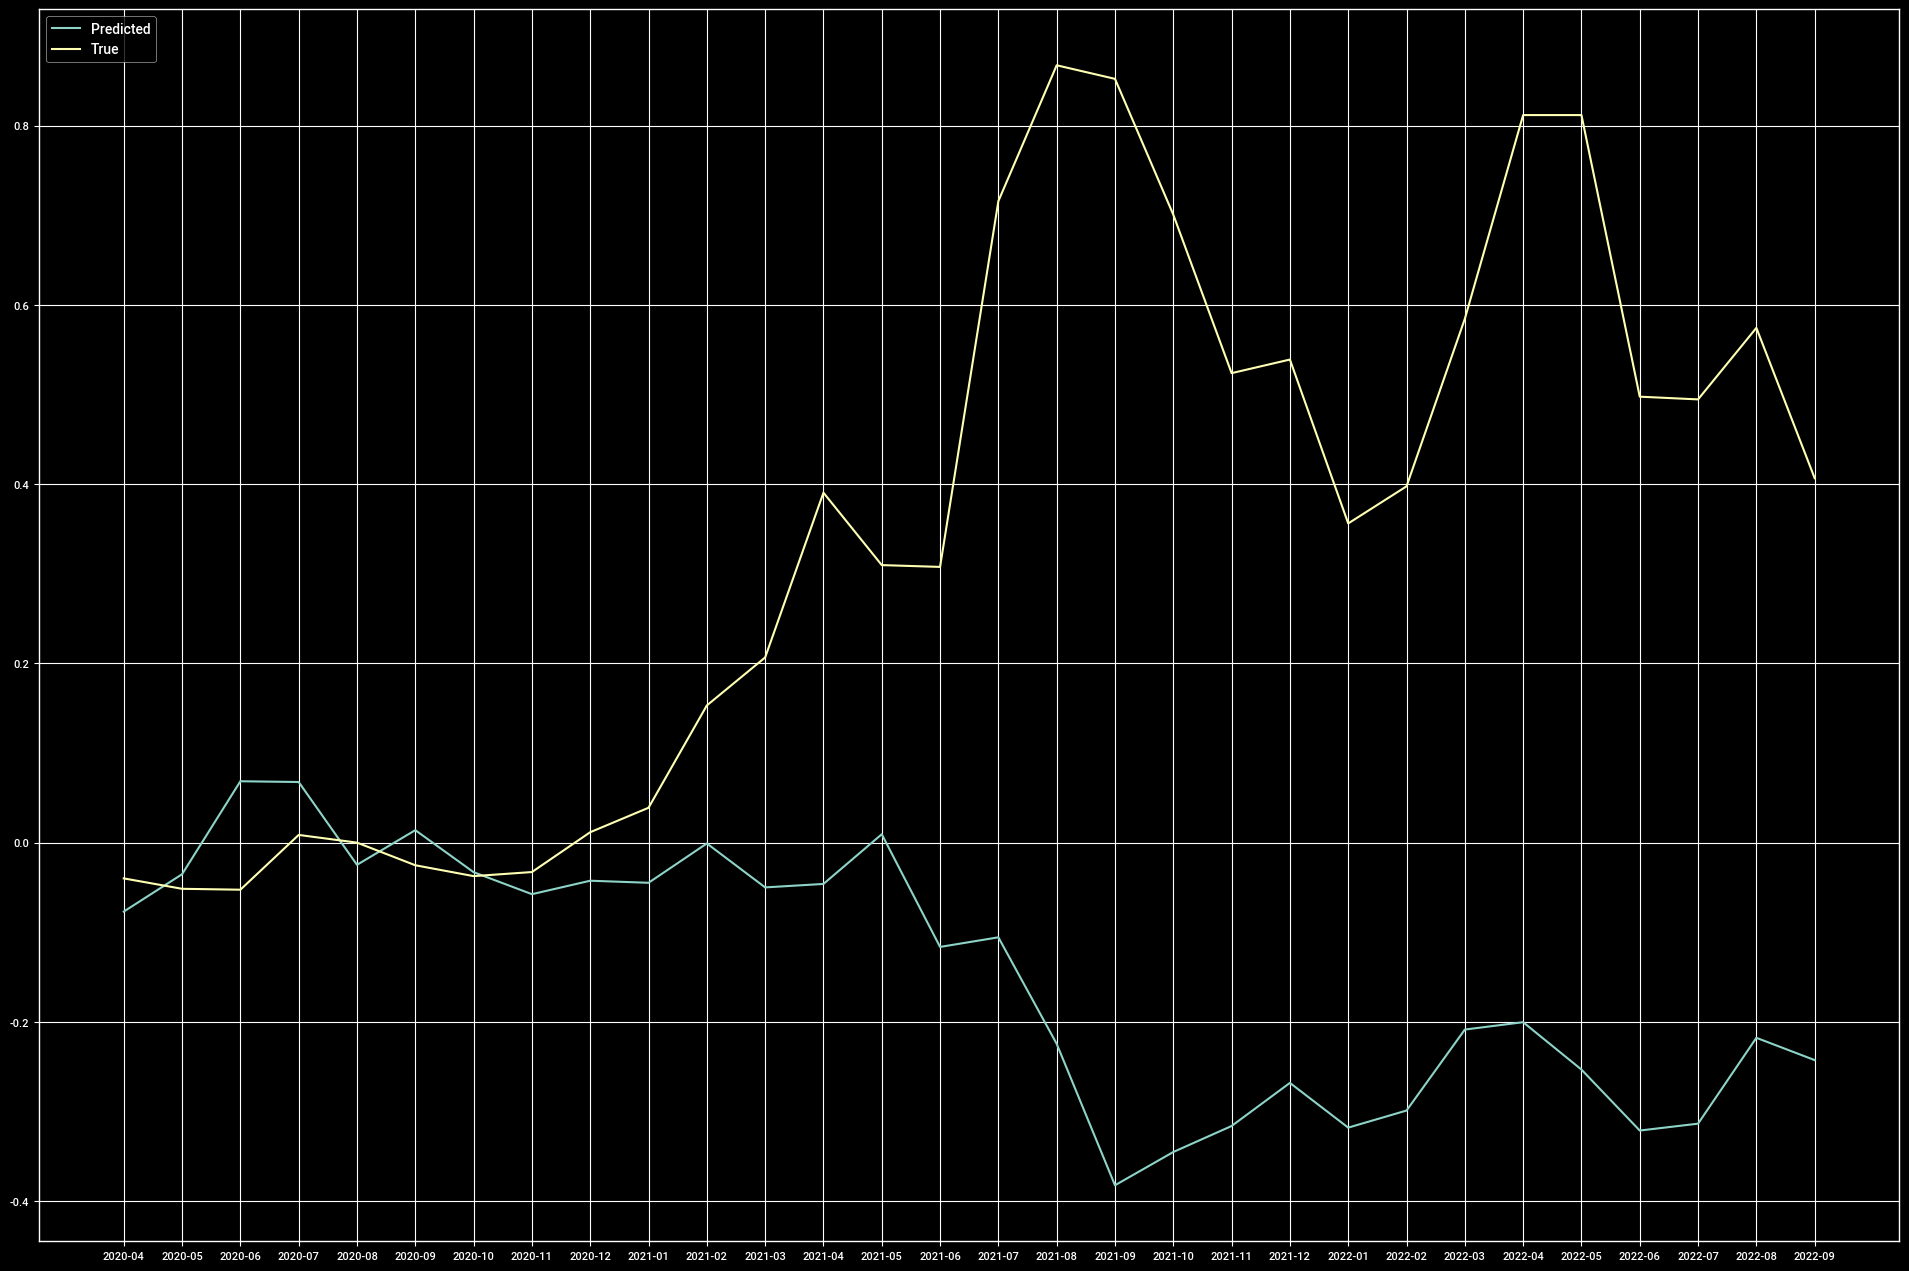

,pred,true,ae
date,,,
2020-04,-0.076794,-0.039768,0.037025
2020-05,-0.035137,-0.051385,0.016247
2020-06,0.068591,-0.052395,0.120985
2020-07,0.067742,0.008716,0.059026
2020-08,-0.024633,0.000131,0.024764
2020-09,0.014027,-0.025122,0.039149
2020-10,-0.032849,-0.037243,0.004394
2020-11,-0.057391,-0.032698,0.024693
2020-12,-0.042375,0.011747,0.054122


In [40]:
adj_df_close = pd.DataFrame({
    'date' : list(adj_data.index[model.train_size:]),
    'pred' : adj_y_pred_close,
    'true' : adj_y_true_close,
    'ae' : abs(adj_y_pred_close - adj_y_true_close)
}).set_index('date')
print('MAE : ', np.mean(adj_df_close['ae']))

plt.figure(figsize=(24,16), facecolor='black')
style.use('dark_background')
plt.plot(adj_df_close['pred'], label = 'Predicted')
plt.plot(adj_df_close['true'], label = "True")
plt.legend(loc = 'upper left')
plt.show()

adj_df_close

In [ ]:
task = 'tgt'
model = da_rnn(file_data = data, target = task, parallel = False, learning_rate = learning_rate, batch_size=batch)  # target = close or tgt
model.train(n_epochs = 2000)
PATH = path + f"/models/UNID_DARNN_data_Target-{task}.pth"
torch.save(model.state_dict(), PATH)

y_pred_tgt = model.predict()
y_true_tgt = model.y[model.train_size:]

plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.show()

plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.show()

plt.figure()
plt.plot(y_pred_tgt, label = 'Predicted')
plt.plot(model.y[model.train_size:], label = "True")
plt.legend(loc = 'upper left')
plt.show()

MAE :  0.3067825109460482


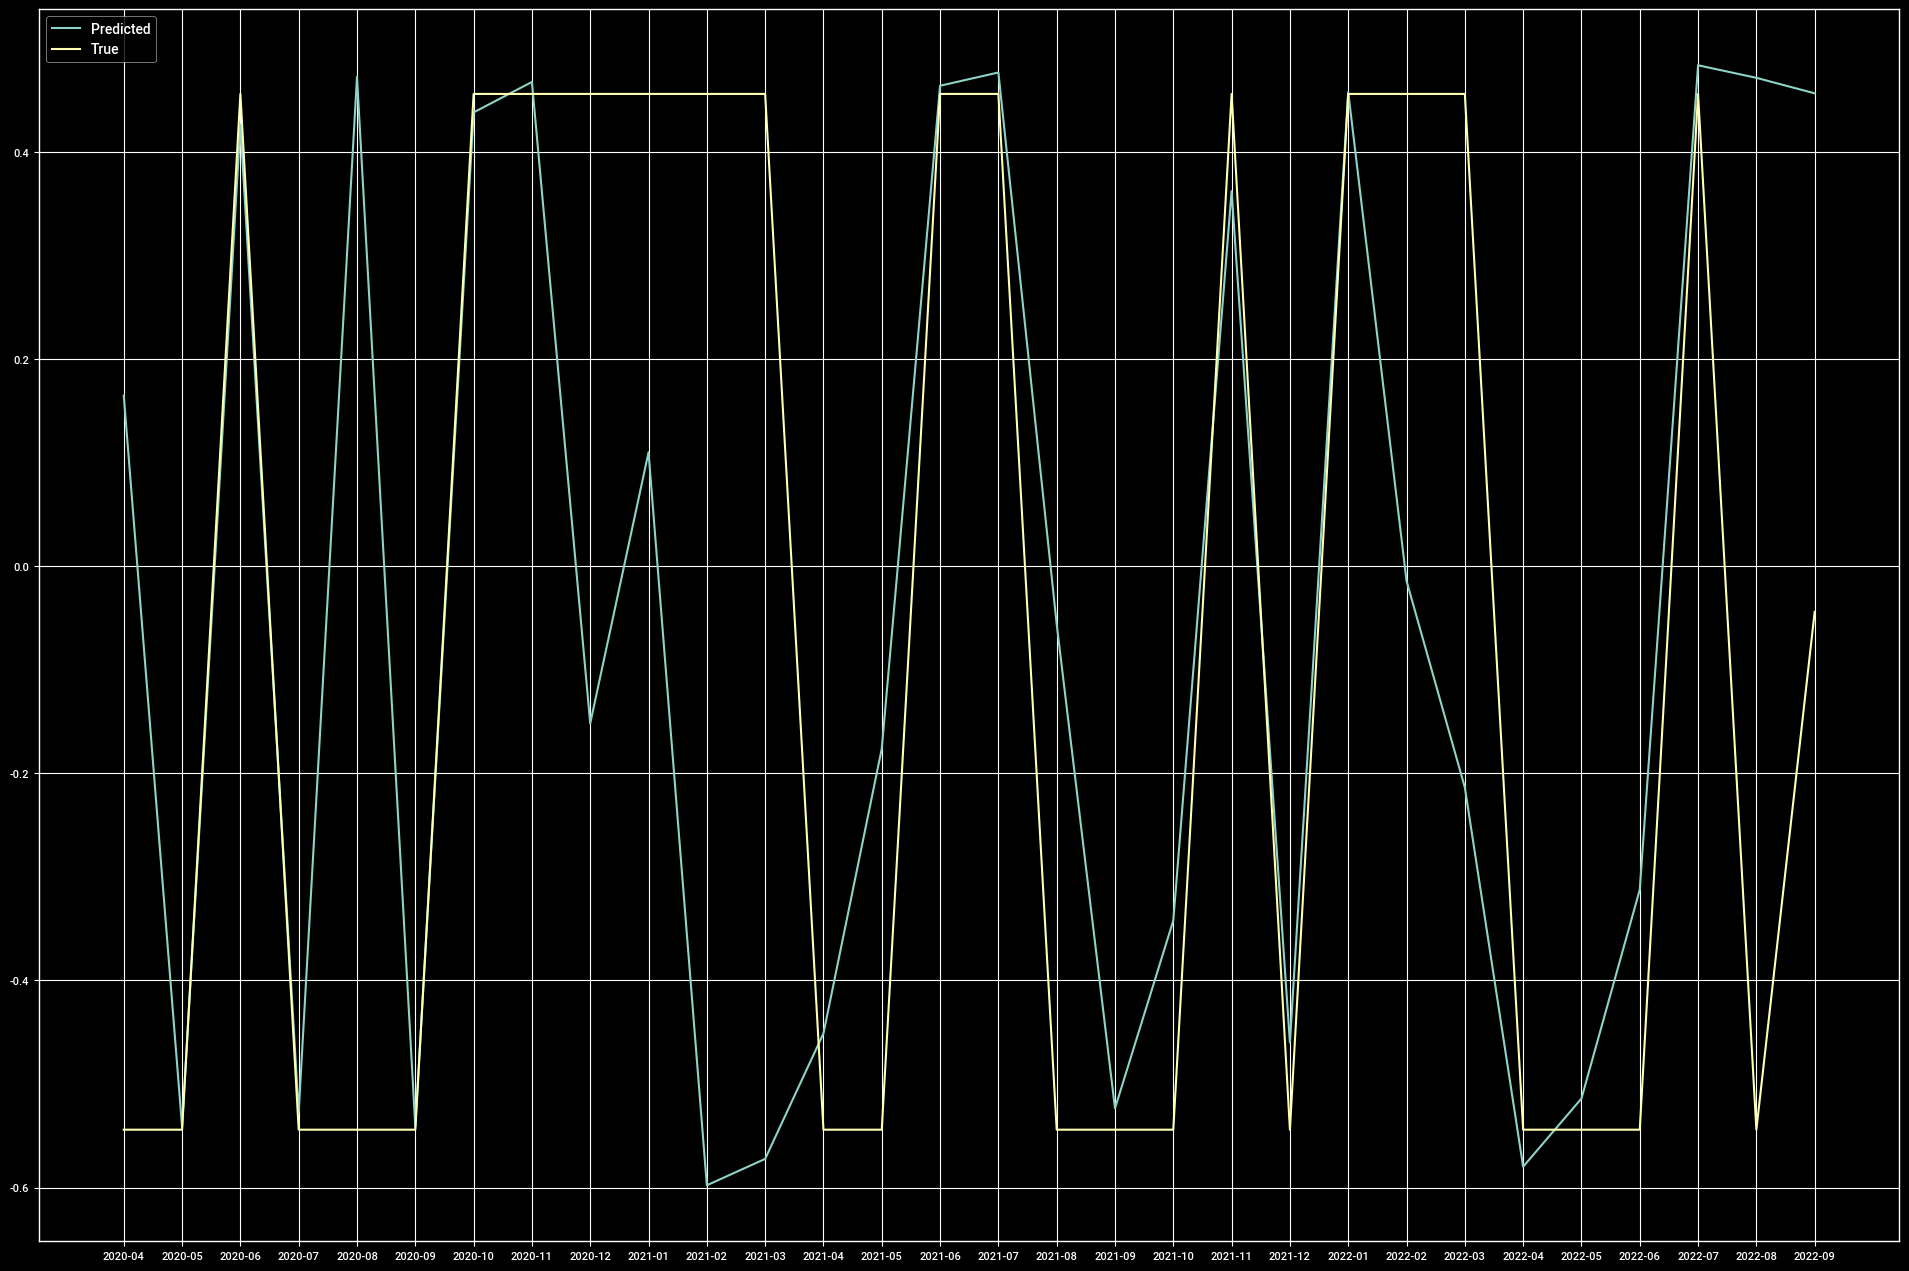

,pred,true,ae
date,,,
2020-04,0.164590,-0.544118,0.708707
2020-05,-0.541237,-0.544118,0.002881
2020-06,0.426272,0.455882,0.029610
2020-07,-0.527233,-0.544118,0.016885
2020-08,0.472425,-0.544118,1.016543
2020-09,-0.541090,-0.544118,0.003028
2020-10,0.438064,0.455882,0.017818
2020-11,0.467448,0.455882,0.011566
2020-12,-0.151873,0.455882,0.607755


In [41]:
df_tgt = pd.DataFrame({
    'date' : list(data.index[model.train_size:]),
    'pred' : y_pred_tgt,
    'true' : y_true_tgt,
    'ae' : abs(y_pred_tgt - y_true_tgt)
}).set_index('date')
print('MAE : ', np.mean(df_tgt['ae']))

plt.figure(figsize=(24,16), facecolor='black')
style.use('dark_background')
plt.plot(df_tgt['pred'], label = 'Predicted')
plt.plot(df_tgt['true'], label = "True")
plt.legend(loc = 'upper left')
plt.show()

df_tgt

In [ ]:
task = 'close'
model = da_rnn(file_data = data, target = task, parallel = False, learning_rate = learning_rate, batch_size=batch)  # target = close or tgt
model.train(n_epochs = 2000)
PATH = path + f"/models/UNID_DARNN_data_Target-{task}.pth"
torch.save(model.state_dict(), PATH)

y_pred_close = model.predict()
y_true_close = model.y[model.train_size:]

plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.show()

plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.show()

plt.figure()
plt.plot(y_pred_close, label = 'Predicted')
plt.plot(model.y[model.train_size:], label = "True")
plt.legend(loc = 'upper left')
plt.show()

MAE :  0.44100709268181887


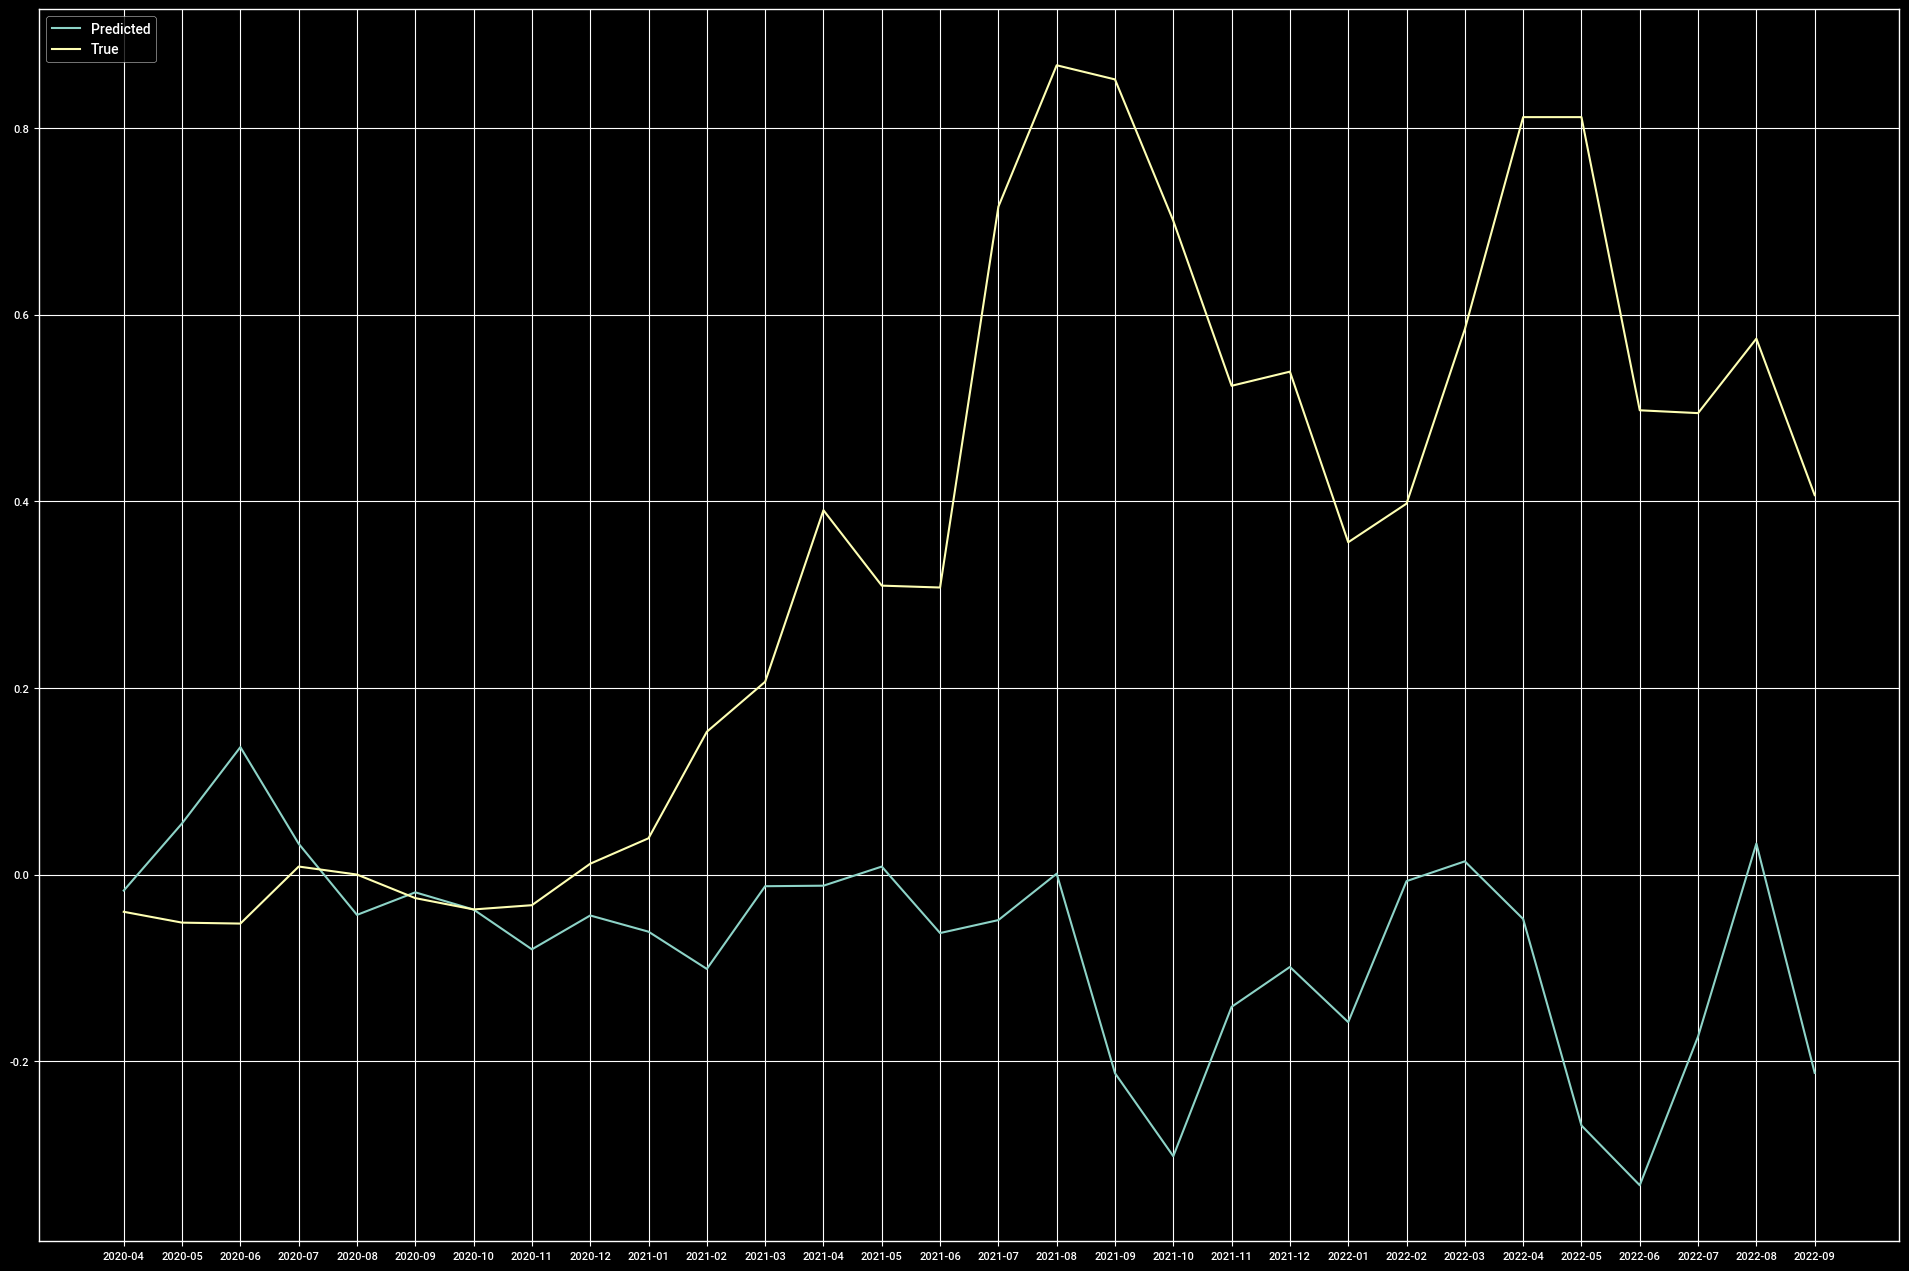

,pred,true,ae
date,,,
2020-04,-0.016997,-0.039768,0.022772
2020-05,0.054996,-0.051385,0.106381
2020-06,0.136685,-0.052395,0.189080
2020-07,0.033157,0.008716,0.024441
2020-08,-0.043079,0.000131,0.043210
2020-09,-0.018905,-0.025122,0.006217
2020-10,-0.037379,-0.037243,0.000135
2020-11,-0.079997,-0.032698,0.047299
2020-12,-0.043719,0.011747,0.055466


In [42]:
df_close = pd.DataFrame({
    'date' : list(data.index[model.train_size:]),
    'pred' : y_pred_close,
    'true' : y_true_close,
    'ae' : abs(y_pred_close - y_true_close)
}).set_index('date')
print('MAE : ', np.mean(df_close['ae']))

plt.figure(figsize=(24,16), facecolor='black')
style.use('dark_background')
plt.plot(df_close['pred'], label = 'Predicted')
plt.plot(df_close['true'], label = "True")
plt.legend(loc = 'upper left')
plt.show()

df_close